In [3]:
import numpy as np
import re

In [4]:
RUN_SEP = '========================================='

def process_runs(results_file_name, params_to_extract):
  results = []
  with open(results_file_name, 'r') as file:
    content = file.read()
    runs = content.split(sep=RUN_SEP)
    
    for run in runs:
      scores_match = re.search('FeCAM top1 curve: (\[.*,.*,.*,.*,.*,.*\])', run)
      scores = np.array(eval(scores_match.group(1)))
      
      params = {}
      for param in params_to_extract:
        param_match = re.search(f'=>\s{param}:\s(.*)\\n', run)
        params[param] = param_match.group(1)
      
      results.append({ 'params': params, 'scores': scores })
            
  return results

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_heatmap(title, x_label, x_tics, y_label, y_tics, values):
    plt.figure(figsize=(10, 8))
    plt.title(title)

    sns.heatmap(values, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=x_tics, yticklabels=y_tics)

    plt.show()

### Grid po lr, alpha i beta przy loss = MSE + Mahalanobis na małej liczbie epok (100)

In [6]:
results = process_runs('results/grid_ae_mse_maha.out', ['lr', 'maha_alpha', 'maha_beta'])

In [7]:
results[:10]

[{'params': {'lr': '0.1', 'maha_alpha': '1', 'maha_beta': '1'},
  'scores': array([6.9 , 6.23, 4.57, 3.9 , 3.64, 2.63])},
 {'params': {'lr': '0.1', 'maha_alpha': '1', 'maha_beta': '5'},
  'scores': array([9.96, 7.03, 6.06, 5.24, 4.4 , 3.78])},
 {'params': {'lr': '0.1', 'maha_alpha': '1', 'maha_beta': '10'},
  'scores': array([12.56,  8.17,  6.5 ,  5.36,  4.42,  3.77])},
 {'params': {'lr': '0.1', 'maha_alpha': '1', 'maha_beta': '50'},
  'scores': array([9.16, 6.88, 5.37, 4.74, 4.12, 3.64])},
 {'params': {'lr': '0.1', 'maha_alpha': '1', 'maha_beta': '100'},
  'scores': array([7.48, 6.78, 4.76, 4.16, 3.74, 3.42])},
 {'params': {'lr': '0.1', 'maha_alpha': '5', 'maha_beta': '1'},
  'scores': array([8.48, 6.82, 6.07, 4.99, 4.34, 3.44])},
 {'params': {'lr': '0.1', 'maha_alpha': '5', 'maha_beta': '5'},
  'scores': array([5.64, 4.23, 3.37, 2.86, 2.69, 2.31])},
 {'params': {'lr': '0.1', 'maha_alpha': '5', 'maha_beta': '10'},
  'scores': array([7.14, 5.63, 3.74, 3.42, 3.3 , 2.93])},
 {'params': {

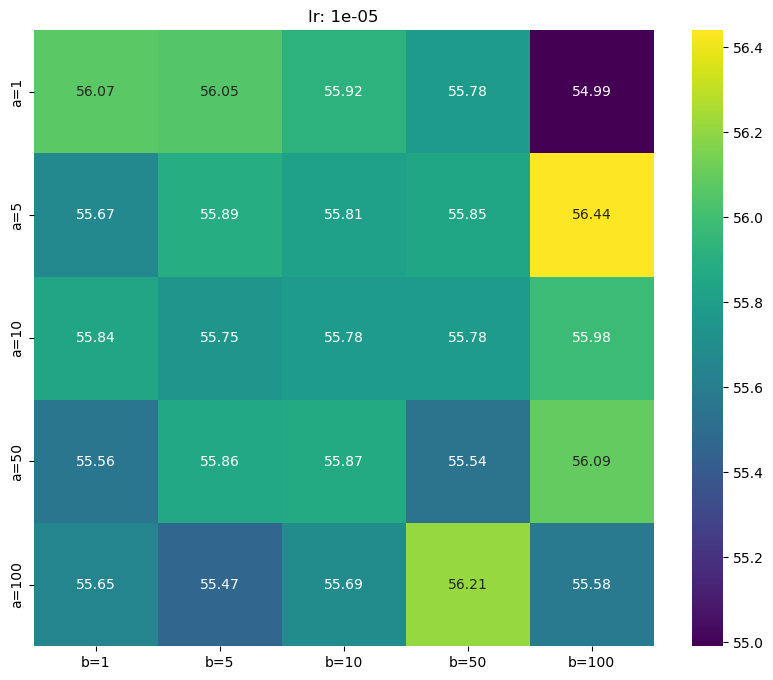

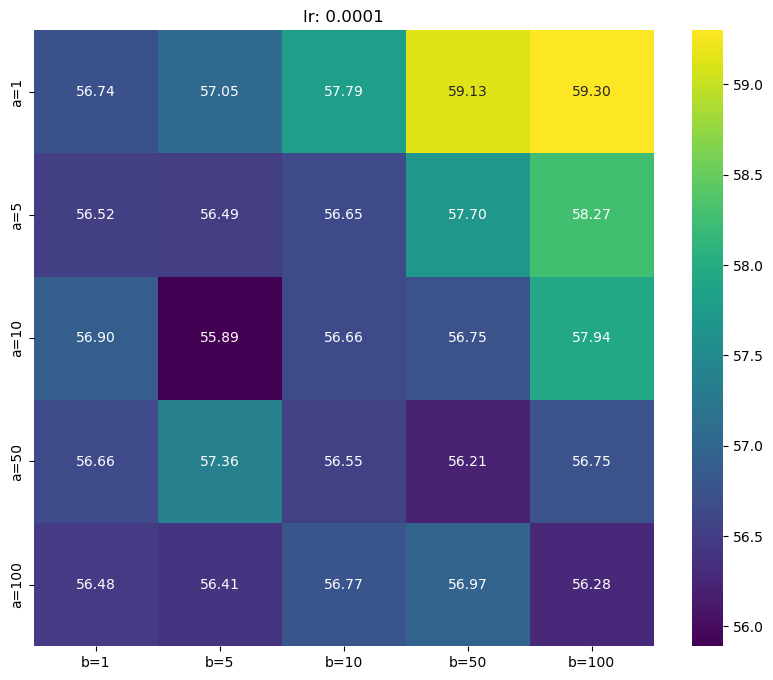

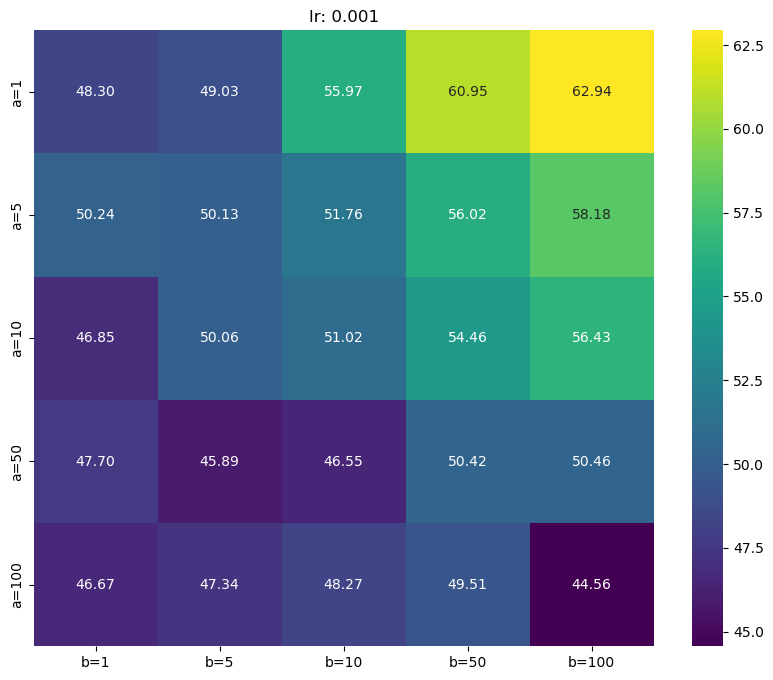

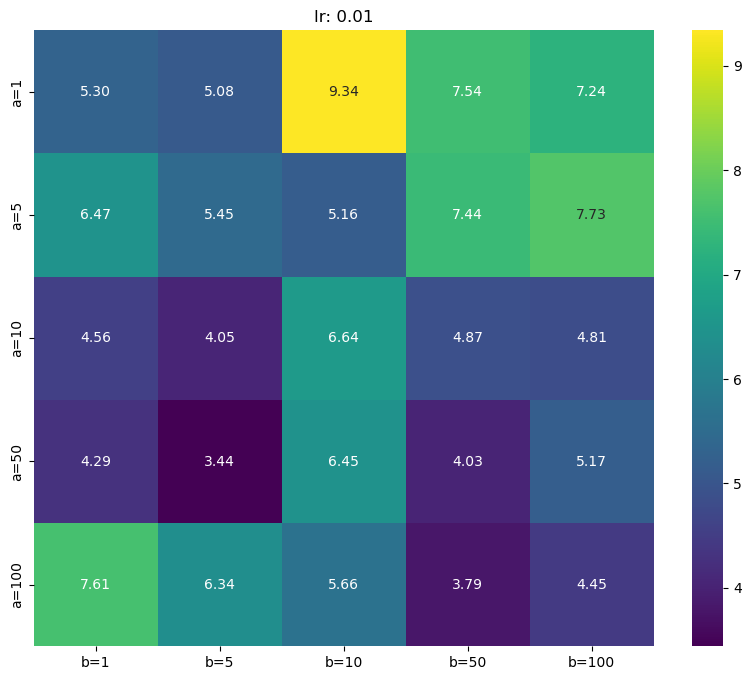

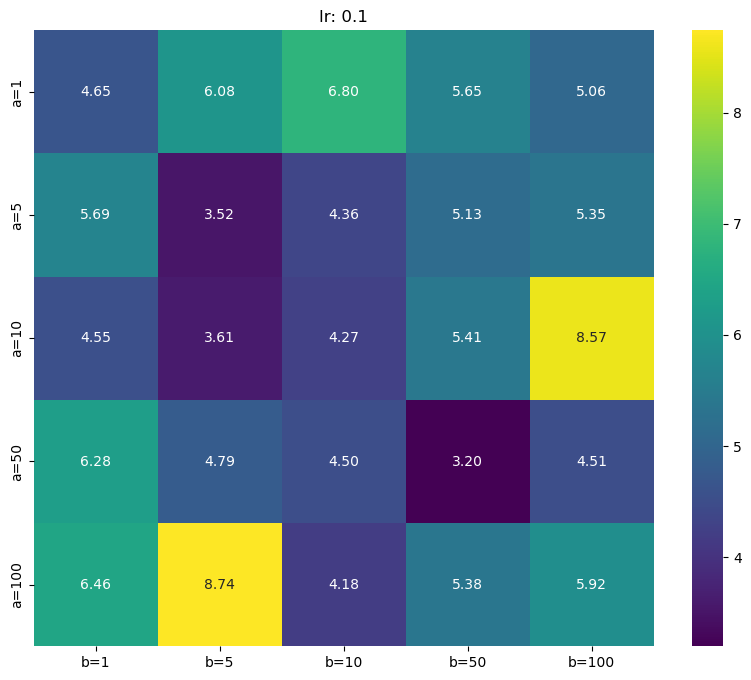

In [8]:
learning_rates = map(lambda result: eval(result['params']['lr']), results)
learning_rates = np.sort(np.unique(list(learning_rates)))

alphas = map(lambda result: result['params']['maha_alpha'], results)
alphas = map(lambda x: eval(x), alphas)
alphas = np.sort(np.unique(list(alphas)))
alphas = np.array(list(map(lambda x: f'a={x}', alphas)))

betas = map(lambda result: result['params']['maha_beta'], results)
betas = map(lambda x: eval(x), betas)
betas = np.sort(np.unique(list(betas)))
betas = np.array(list(map(lambda x: f'b={x}', betas)))

for lr in learning_rates:
  lr_results = filter(lambda x: eval(x['params']['lr']) == lr, results)
  lr_results = map(lambda x: x['scores'].mean(), lr_results)
  lr_results = map(lambda x: np.round(x, decimals=2), lr_results)
  lr_results = np.array(list(lr_results))
  draw_heatmap(
    title=f'lr: {lr}', 
    y_label='alpha', y_tics=alphas,
    x_label='beta', x_tics=betas,
    values=lr_results.reshape((len(alphas), len(betas))))

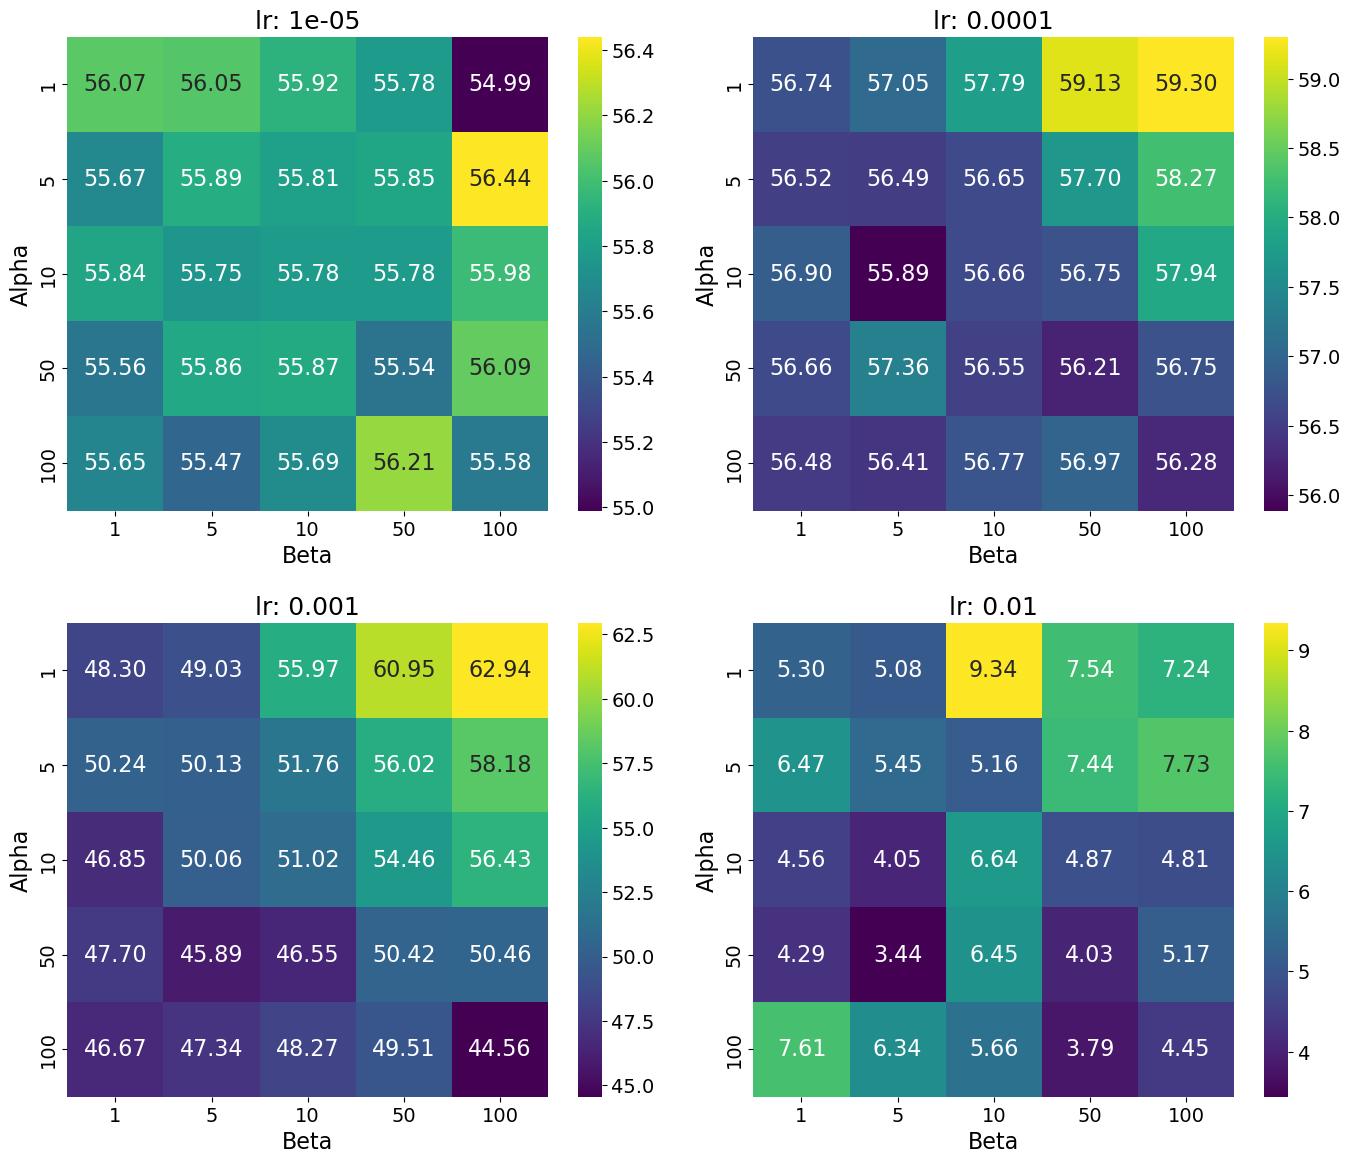

In [18]:
learning_rates = map(lambda result: eval(result['params']['lr']), results)
learning_rates = np.sort(np.unique(list(learning_rates)))

alphas = map(lambda result: result['params']['maha_alpha'], results)
alphas = map(lambda x: eval(x), alphas)
alphas = np.sort(np.unique(list(alphas)))
alphas = np.array(list(map(lambda x: f'{x}', alphas)))

betas = map(lambda result: result['params']['maha_beta'], results)
betas = map(lambda x: eval(x), betas)
betas = np.sort(np.unique(list(betas)))
betas = np.array(list(map(lambda x: f'{x}', betas)))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, lr in enumerate(learning_rates[:4]):
  lr_results = filter(lambda x: eval(x['params']['lr']) == lr, results)
  lr_results = map(lambda x: x['scores'].mean(), lr_results)
  lr_results = map(lambda x: np.round(x, decimals=2), lr_results)
  lr_results = np.array(list(lr_results))

  ax = sns.heatmap(lr_results.reshape((len(alphas), len(betas))), 
                annot=True, annot_kws={"size": 16}, fmt=".2f", cmap="viridis",
                xticklabels=alphas, yticklabels=betas, ax=axes[i//2][i%2])
  
  ax.set_title(f'lr: {lr}', fontsize=18)
  ax.set_ylabel('Alpha', fontsize=16)
  ax.set_xlabel('Beta', fontsize=16)

  ax.tick_params(axis='x', labelsize=14)
  ax.tick_params(axis='y', labelsize=14)

  colorbar = ax.collections[0].colorbar
  colorbar.ax.tick_params(labelsize=14)
  colorbar.ax.yaxis.label.set_size(14)

plt.tight_layout(pad=2.0)  # Adjust the padding between and around the subplots
plt.show()

### Powtórzenie najlepszych wyników z grida gdzie loss = MSE + Mahalanobis

In [9]:
results = process_runs('results/best_maha_mse_runs.out', ['lr', 'maha_alpha', 'maha_beta', 'epochs'])

In [10]:
epochs = list(map(lambda x: x['params']['epochs'], results))
lrs = list(map(lambda x: x['params']['lr'], results))
alphas = list(map(lambda x: x['params']['maha_alpha'], results))
betas = list(map(lambda x: x['params']['maha_beta'], results))
scores = np.array(list(map(lambda x: x['scores'], results)))

In [11]:
import pandas as pd

df = pd.DataFrame({ 'epochs': epochs, 'lr': lrs, 'alpha': alphas, 'beta': betas })

for i in range(6):
  df[f'Task {i}'] = scores[:, i]

df['Mean'] = scores.mean(axis=1)

cols = pd.MultiIndex.from_tuples([
  ('PARAMS', 'Epochs'), ('PARAMS', 'LR'), ('PARAMS', 'Alpha'), ('PARAMS', 'Beta'),
  ('SCORES', 'Task 0'), ('SCORES', 'Task 1'), ('SCORES', 'Task 2'),
  ('SCORES', 'Task 3'), ('SCORES', 'Task 4'), ('SCORES', 'Task 5'),
  ('SCORES', 'Mean')  
])

df.columns = cols
df

PARAMS                    SCORES                                     \
  Epochs      LR Alpha Beta Task 0 Task 1 Task 2 Task 3 Task 4 Task 5   
0   1000  0.0001     1   50  82.10  66.97  59.64  53.12  48.08  44.14   
1   1000  0.0001     1  100  82.58  68.90  62.30  56.19  51.30  47.51   
2   1000   1e-05     5  100  76.84  64.10  55.81  49.21  44.06  39.59   
3   1000   0.001     1  100  82.00  70.35  62.67  56.60  51.96  48.12   

              
        Mean  
0  59.008333  
1  61.463333  
2  54.935000  
3  61.950000

### Grid po lr, architektura = [256, 128, 64, 32, 16], loss = MSE

In [30]:
# grid po lr - samo mse jako loss
results = process_runs('results/grid_ae_mse.out', ['lr', 'maha_alpha', 'maha_beta', 'epochs'])
epochs = list(map(lambda x: x['params']['epochs'], results))
lrs = list(map(lambda x: x['params']['lr'], results))
alphas = list(map(lambda x: x['params']['maha_alpha'], results))
betas = list(map(lambda x: x['params']['maha_beta'], results))
scores = np.array(list(map(lambda x: x['scores'], results)))

In [31]:
import pandas as pd

df = pd.DataFrame({ 'epochs': epochs, 'lr': lrs, 'alpha': alphas, 'beta': betas })

for i in range(6):
  df[f'Task {i}'] = scores[:, i]

df['Mean'] = scores.mean(axis=1)

cols = pd.MultiIndex.from_tuples([
  ('PARAMS', 'Epochs'), ('PARAMS', 'LR'), ('PARAMS', 'Alpha'), ('PARAMS', 'Beta'),
  ('SCORES', 'Task 0'), ('SCORES', 'Task 1'), ('SCORES', 'Task 2'),
  ('SCORES', 'Task 3'), ('SCORES', 'Task 4'), ('SCORES', 'Task 5'),
  ('SCORES', 'Mean')  
])

df.columns = cols
df

PARAMS                    SCORES                                     \
   Epochs      LR Alpha Beta Task 0 Task 1 Task 2 Task 3 Task 4 Task 5   
0    1000     0.1     0    1   5.22   4.35   2.33   2.33   2.11   1.90   
1    1000    0.05     0    1   3.84   3.20   2.74   2.40   2.13   1.92   
2    1000    0.01     0    1   4.54   3.78   3.26   2.85   2.53   2.28   
3    1000   0.005     0    1   9.40   7.83   6.74   5.90   5.24   4.72   
4    1000   0.001     0    1  70.86  58.93  51.34  45.41  40.50  36.45   
5    1000  0.0005     0    1  79.26  64.55  56.51  50.16  45.27  41.88   
6    1000  0.0001     0    1  82.12  70.02  61.74  55.39  50.49  46.86   
7    1000   5e-05     0    1  82.64  71.22  63.60  58.01  52.68  48.94   
8    1000   1e-05     0    1  83.44  72.70  65.77  59.61  54.87  51.34   
9    1000   5e-06     0    1  83.56  72.45  66.11  60.61  56.06  52.95   
10   1000   1e-06     0    1  83.52  73.27  66.44  59.96  55.10  51.57   
11   1000   5e-07     0    1  82.36  67.93  62.31  57.25  52.82  49.19   
12   1000   1e-07     0    1  73.96  60.92  51.84  45.25  39.90  36.06   
13   1000   5e-08     0    1  32.64  25.15  22.10  18.25  15.61  13.90   
14   1000   1e-08     0    1   2.82   2.52   2.36   1.82   1.56   1.40   

               
         Mean  
0    3.040000  
1    2.705000  
2    3.206667  
3    6.638333  
4   50.581667  
5   56.271667  
6   61.103333  
7   62.848333  
8   64.621667  
9   65.290000  
10  64.976667  
11  61.976667  
12  51.321667  
13  21.275000  
14   2.080000

In [32]:
# LATEX
columns_to_drop = ['Epochs', 'Alpha', 'Beta']
latex_df = df.drop(columns=columns_to_drop, level=1)
latex_df.round(2).to_latex()

'\\begin{tabular}{llrrrrrrr}\n\\toprule\n & PARAMS & \\multicolumn{7}{r}{SCORES} \\\\\n & LR & Task 0 & Task 1 & Task 2 & Task 3 & Task 4 & Task 5 & Mean \\\\\n\\midrule\n0 & 0.1 & 5.220000 & 4.350000 & 2.330000 & 2.330000 & 2.110000 & 1.900000 & 3.040000 \\\\\n1 & 0.05 & 3.840000 & 3.200000 & 2.740000 & 2.400000 & 2.130000 & 1.920000 & 2.710000 \\\\\n2 & 0.01 & 4.540000 & 3.780000 & 3.260000 & 2.850000 & 2.530000 & 2.280000 & 3.210000 \\\\\n3 & 0.005 & 9.400000 & 7.830000 & 6.740000 & 5.900000 & 5.240000 & 4.720000 & 6.640000 \\\\\n4 & 0.001 & 70.860000 & 58.930000 & 51.340000 & 45.410000 & 40.500000 & 36.450000 & 50.580000 \\\\\n5 & 0.0005 & 79.260000 & 64.550000 & 56.510000 & 50.160000 & 45.270000 & 41.880000 & 56.270000 \\\\\n6 & 0.0001 & 82.120000 & 70.020000 & 61.740000 & 55.390000 & 50.490000 & 46.860000 & 61.100000 \\\\\n7 & 5e-05 & 82.640000 & 71.220000 & 63.600000 & 58.010000 & 52.680000 & 48.940000 & 62.850000 \\\\\n8 & 1e-05 & 83.440000 & 72.700000 & 65.770000 & 59.610000 &

### Grid po architekturze AutoEnkodera i lr, loss = MSE

In [33]:
results = process_runs('results/grid_neurons.out', ['epochs', 'lr', 'layers_neurons', 'maha_beta', 'maha_alpha'])

In [34]:
epochs = list(map(lambda x: x['params']['epochs'], results))
lrs = list(map(lambda x: x['params']['lr'], results))
layers = list(map(lambda x: x['params']['layers_neurons'], results))
alphas = list(map(lambda x: x['params']['maha_alpha'], results))
betas = list(map(lambda x: x['params']['maha_beta'], results))
scores = np.array(list(map(lambda x: x['scores'], results)))

In [35]:
import pandas as pd

df = pd.DataFrame({ 'epochs': epochs, 'lr': lrs, 'layers': layers, 'alpha': alphas, 'beta': betas })

for i in range(6):
  df[f'Task {i}'] = scores[:, i]

df['Mean'] = scores.mean(axis=1)

cols = pd.MultiIndex.from_tuples([
  ('PARAMS', 'Epochs'), ('PARAMS', 'LR'), ('PARAMS', 'LAYERS'), ('PARAMS', 'Alpha'), ('PARAMS', 'Beta'),
  ('SCORES', 'Task 0'), ('SCORES', 'Task 1'), ('SCORES', 'Task 2'),
  ('SCORES', 'Task 3'), ('SCORES', 'Task 4'), ('SCORES', 'Task 5'),
  ('SCORES', 'Mean')  
])

df.columns = cols
df.round(2)

PARAMS                                                     SCORES         \
   Epochs     LR                            LAYERS Alpha Beta Task 0 Task 1   
0    1000  5e-05           [256, 256, 128, 64, 16]     0    1  82.08  70.03   
1    1000  5e-05            [256, 128, 64, 32, 16]     0    1  82.26  70.28   
2    1000  5e-05       [512, 256, 128, 64, 32, 16]     0    1  80.72  68.13   
3    1000  5e-05  [256, 256, 128, 128, 32, 32, 16]     0    1  81.84  68.68   
4    1000  1e-05           [256, 256, 128, 64, 16]     0    1  82.92  71.72   
5    1000  1e-05            [256, 128, 64, 32, 16]     0    1  82.96  71.27   
6    1000  1e-05       [512, 256, 128, 64, 32, 16]     0    1  82.88  71.37   
7    1000  1e-05  [256, 256, 128, 128, 32, 32, 16]     0    1  83.54  71.93   
8    1000  5e-06           [256, 256, 128, 64, 16]     0    1  83.50  72.57   
9    1000  5e-06            [256, 128, 64, 32, 16]     0    1  83.34  71.42   
10   1000  5e-06       [512, 256, 128, 64, 32, 16]     0    1  83.42  72.10   
11   1000  5e-06  [256, 256, 128, 128, 32, 32, 16]     0    1  83.56  72.28   

                                       
   Task 2 Task 3 Task 4 Task 5   Mean  
0   63.04  57.31  52.89  49.57  62.49  
1   63.87  58.24  54.00  50.52  63.20  
2   59.81  53.60  48.51  44.65  59.24  
3   60.49  54.00  49.06  45.37  59.91  
4   65.31  59.50  55.26  51.82  64.42  
5   64.76  59.32  55.06  51.72  64.18  
6   64.13  57.86  52.84  49.57  63.11  
7   64.76  57.49  52.43  48.97  63.19  
8   65.57  59.66  54.87  51.71  64.65  
9   65.04  59.00  54.31  50.94  64.01  
10  65.64  59.05  54.27  50.75  64.20  
11  65.17  58.59  53.53  50.27  63.90

In [36]:
# LATEX
columns_to_drop = ['Epochs', 'Alpha', 'Beta']
latex_df = df.drop(columns=columns_to_drop, level=1)
latex_df.round(2).to_latex()

'\\begin{tabular}{lllrrrrrrr}\n\\toprule\n & \\multicolumn{2}{r}{PARAMS} & \\multicolumn{7}{r}{SCORES} \\\\\n & LR & LAYERS & Task 0 & Task 1 & Task 2 & Task 3 & Task 4 & Task 5 & Mean \\\\\n\\midrule\n0 & 5e-05 & [256, 256, 128, 64, 16] & 82.080000 & 70.030000 & 63.040000 & 57.310000 & 52.890000 & 49.570000 & 62.490000 \\\\\n1 & 5e-05 & [256, 128, 64, 32, 16] & 82.260000 & 70.280000 & 63.870000 & 58.240000 & 54.000000 & 50.520000 & 63.200000 \\\\\n2 & 5e-05 & [512, 256, 128, 64, 32, 16] & 80.720000 & 68.130000 & 59.810000 & 53.600000 & 48.510000 & 44.650000 & 59.240000 \\\\\n3 & 5e-05 & [256, 256, 128, 128, 32, 32, 16] & 81.840000 & 68.680000 & 60.490000 & 54.000000 & 49.060000 & 45.370000 & 59.910000 \\\\\n4 & 1e-05 & [256, 256, 128, 64, 16] & 82.920000 & 71.720000 & 65.310000 & 59.500000 & 55.260000 & 51.820000 & 64.420000 \\\\\n5 & 1e-05 & [256, 128, 64, 32, 16] & 82.960000 & 71.270000 & 64.760000 & 59.320000 & 55.060000 & 51.720000 & 64.180000 \\\\\n6 & 1e-05 & [512, 256, 128, 64,

### Kontynuacja grida przy loss = MSE + Mahalanobis

In [37]:
results = process_runs('results/grid_ae_mse_maha_2.out', ['lr', 'maha_alpha', 'maha_beta', 'epochs'])

In [38]:
epochs = list(map(lambda x: x['params']['epochs'], results))
lrs = list(map(lambda x: x['params']['lr'], results))
alphas = list(map(lambda x: x['params']['maha_alpha'], results))
betas = list(map(lambda x: x['params']['maha_beta'], results))
scores = np.array(list(map(lambda x: x['scores'], results)))

In [39]:
df = pd.DataFrame({ 'epochs': epochs, 'lr': lrs, 'alpha': alphas, 'beta': betas })

for i in range(6):
  df[f'Task {i}'] = scores[:, i]

df['Mean'] = scores.mean(axis=1)

cols = pd.MultiIndex.from_tuples([
  ('PARAMS', 'Epochs'), ('PARAMS', 'LR'), ('PARAMS', 'Alpha'), ('PARAMS', 'Beta'),
  ('SCORES', 'Task 0'), ('SCORES', 'Task 1'), ('SCORES', 'Task 2'),
  ('SCORES', 'Task 3'), ('SCORES', 'Task 4'), ('SCORES', 'Task 5'),
  ('SCORES', 'Mean')  
])

df.columns = cols
df

PARAMS                    SCORES                                     \
   Epochs      LR Alpha Beta Task 0 Task 1 Task 2 Task 3 Task 4 Task 5   
0     100   0.001     1  200  83.16  72.17  65.36  59.08  54.59  50.85   
1     100   0.001     1  300  83.06  72.37  65.61  59.81  54.48  50.90   
2     100   0.001     1  400  83.22  72.32  65.54  59.66  55.41  52.06   
3     100   0.001     1  500  82.90  72.30  65.74  59.46  54.77  51.64   
4     100   0.001     5  200  80.94  68.15  60.16  53.30  48.20  44.18   
5     100   0.001     5  300  81.90  70.07  62.01  55.61  50.94  47.18   
6     100   0.001     5  400  82.56  71.25  63.39  56.65  51.82  48.13   
7     100   0.001     5  500  82.86  71.12  63.61  57.38  52.43  49.17   
8     100  0.0001     1  200  82.72  71.00  63.44  57.14  52.12  48.50   
9     100  0.0001     1  300  83.06  71.63  64.16  57.96  53.10  49.60   
10    100  0.0001     1  400  83.18  72.33  65.09  58.84  53.93  50.56   
11    100  0.0001     1  500  83.32  72.83  66.04  59.44  54.24  50.75   
12    100  0.0001     5  200  80.72  66.35  58.11  51.28  46.27  41.85   
13    100  0.0001     5  300  81.52  68.00  60.00  53.20  47.87  44.07   
14    100  0.0001     5  400  82.04  69.18  61.36  54.44  49.39  45.43   
15    100  0.0001     5  500  82.24  69.60  61.79  55.11  49.73  46.23   

               
         Mean  
0   64.201667  
1   64.371667  
2   64.701667  
3   64.468333  
4   59.155000  
5   61.285000  
6   62.300000  
7   62.761667  
8   62.486667  
9   63.251667  
10  63.988333  
11  64.436667  
12  57.430000  
13  59.110000  
14  60.306667  
15  60.783333

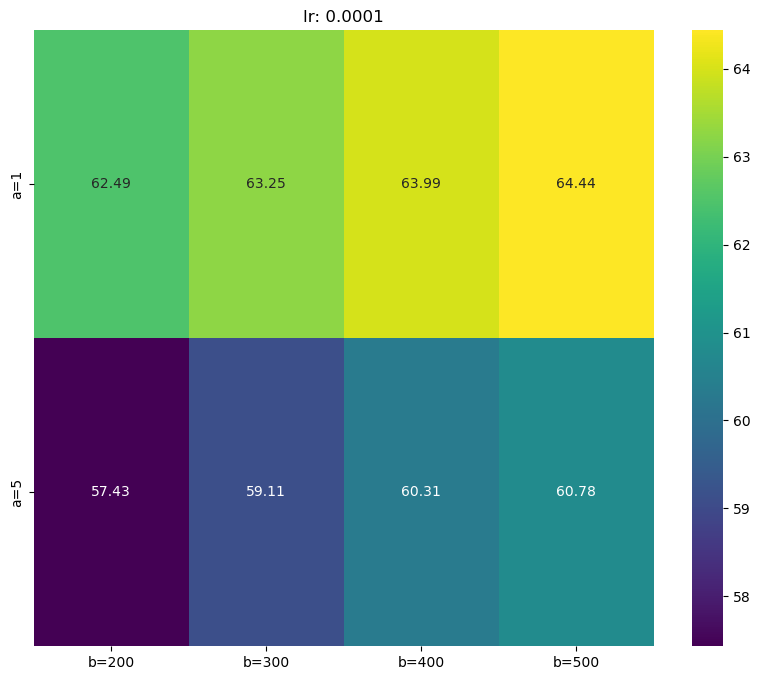

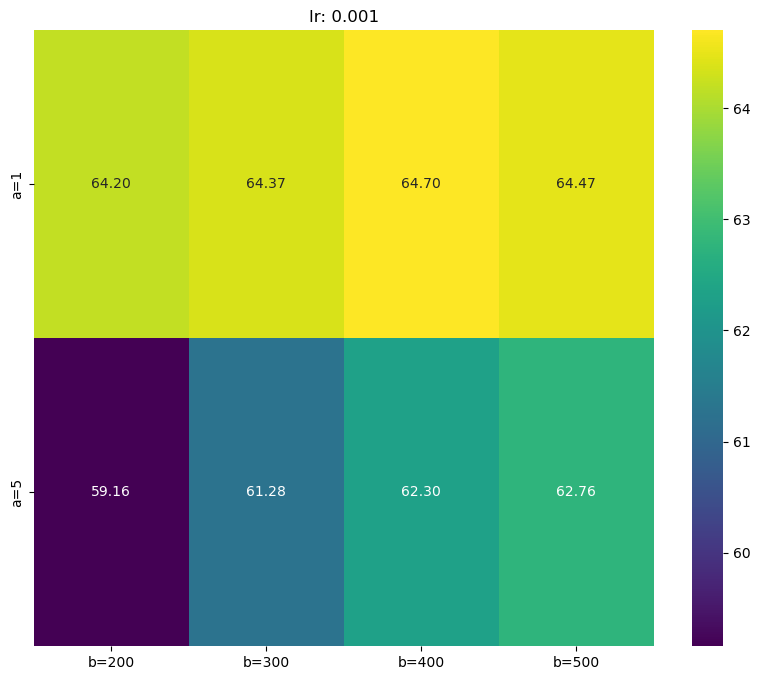

In [40]:
learning_rates = map(lambda result: eval(result['params']['lr']), results)
learning_rates = np.sort(np.unique(list(learning_rates)))

alphas = map(lambda result: result['params']['maha_alpha'], results)
alphas = map(lambda x: eval(x), alphas)
alphas = np.sort(np.unique(list(alphas)))
alphas = np.array(list(map(lambda x: f'a={x}', alphas)))

betas = map(lambda result: result['params']['maha_beta'], results)
betas = map(lambda x: eval(x), betas)
betas = np.sort(np.unique(list(betas)))
betas = np.array(list(map(lambda x: f'b={x}', betas)))

for lr in learning_rates:
  lr_results = filter(lambda x: eval(x['params']['lr']) == lr, results)
  lr_results = map(lambda x: x['scores'].mean(), lr_results)
  lr_results = map(lambda x: np.round(x, decimals=2), lr_results)
  lr_results = np.array(list(lr_results))
  draw_heatmap(
    title=f'lr: {lr}', 
    x_label='alpha', x_tics=betas,
    y_label='beta', y_tics=alphas,
    values=lr_results.reshape((len(alphas), len(betas))))

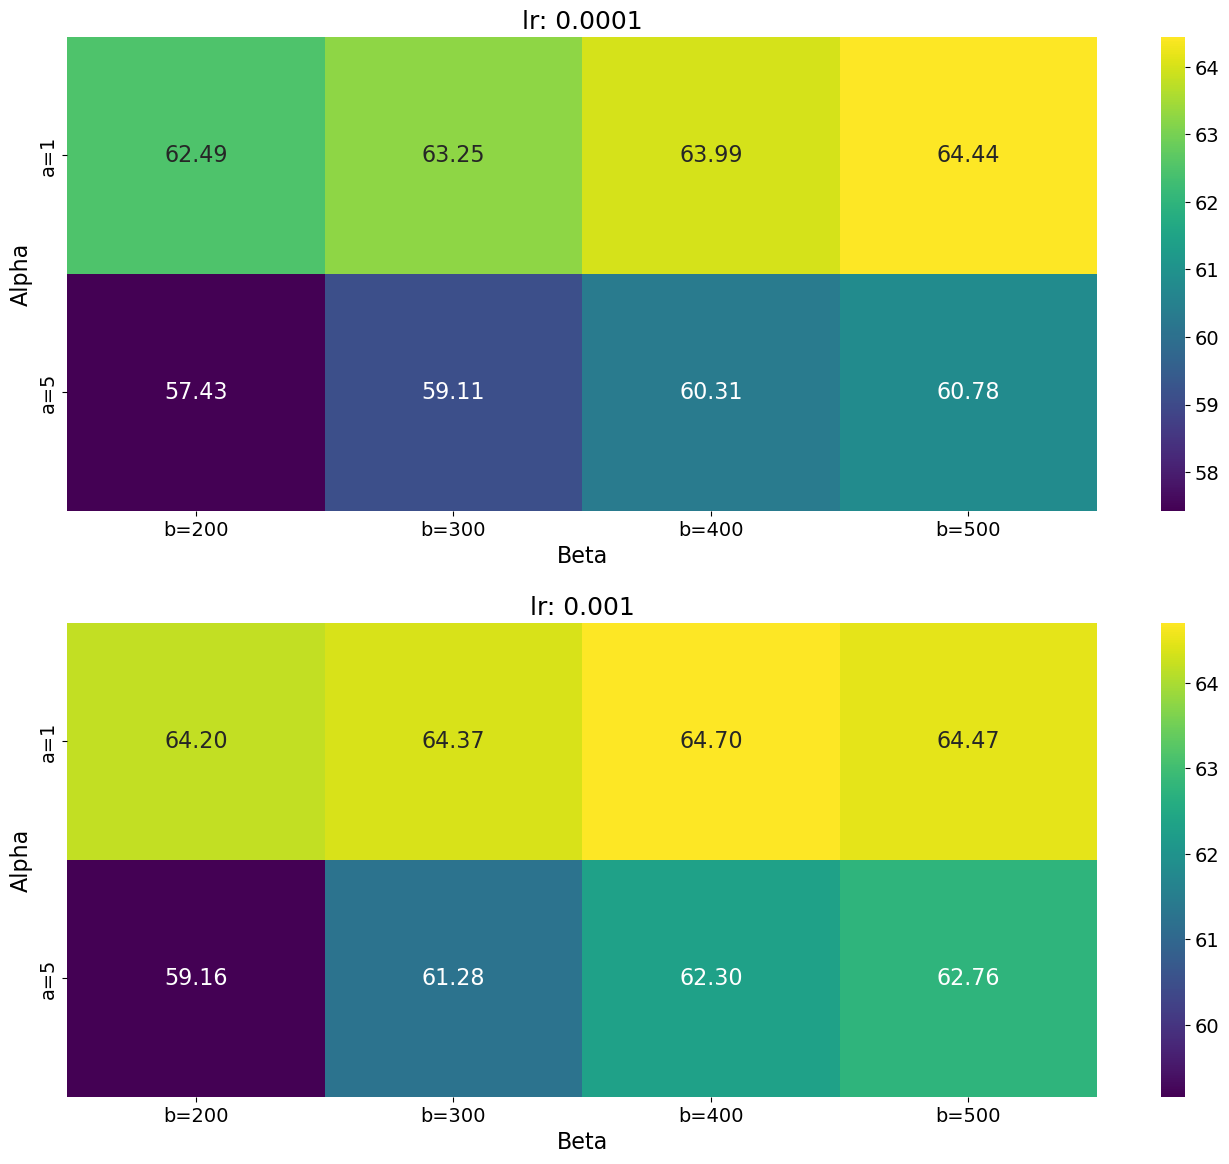

In [42]:
learning_rates = map(lambda result: eval(result['params']['lr']), results)
learning_rates = np.sort(np.unique(list(learning_rates)))

alphas = map(lambda result: result['params']['maha_alpha'], results)
alphas = map(lambda x: eval(x), alphas)
alphas = np.sort(np.unique(list(alphas)))
alphas = np.array(list(map(lambda x: f'a={x}', alphas)))

betas = map(lambda result: result['params']['maha_beta'], results)
betas = map(lambda x: eval(x), betas)
betas = np.sort(np.unique(list(betas)))
betas = np.array(list(map(lambda x: f'b={x}', betas)))

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

for i, lr in enumerate(learning_rates):
  lr_results = filter(lambda x: eval(x['params']['lr']) == lr, results)
  lr_results = map(lambda x: x['scores'].mean(), lr_results)
  lr_results = map(lambda x: np.round(x, decimals=2), lr_results)
  lr_results = np.array(list(lr_results))

  ax = sns.heatmap(lr_results.reshape((len(alphas), len(betas))), 
                annot=True, annot_kws={"size": 16}, fmt=".2f", cmap="viridis",
                xticklabels=betas, yticklabels=alphas, ax=axes[i])
  
  ax.set_title(f'lr: {lr}', fontsize=18)
  ax.set_ylabel('Alpha', fontsize=16)
  ax.set_xlabel('Beta', fontsize=16)

  ax.tick_params(axis='x', labelsize=14)
  ax.tick_params(axis='y', labelsize=14)

  colorbar = ax.collections[0].colorbar
  colorbar.ax.tick_params(labelsize=14)
  colorbar.ax.yaxis.label.set_size(14)

plt.tight_layout(pad=2.0)  # Adjust the padding between and around the subplots
plt.show()

Ponieważ loss jest liczony wzorem `losses = alpha * maha_dists + beta * rec_costs` i widzimy tym lepsze wyniki im większy jest stosunek beta do alfa, podejrzewam że częśc z Mahalanobisem przeszkadza - ponadto najlepsze wyniki w tej serii eksperymentów uzyskaliśmy przy Autoenkoderze z lossem MSE.